In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline
from scipy.optimize import curve_fit
from decimal import Decimal

#turn off warnings
import warnings
warnings.filterwarnings("ignore")

### load data

In [2]:
joint_ihmp_runtime = pd.read_csv('../../data/simulations/ihmp/runtime/ihmp-joint-rpca-runtime.csv', index_col=0)
joint_ihmp_runtime.reset_index(inplace=True)
joint_ihmp_runtime.drop(columns=['index'], inplace=True)
#display(joint_ihmp_runtime)
factor_to_n = dict(zip(joint_ihmp_runtime['factor'], joint_ihmp_runtime['n features']))

In [3]:
with open('../../data/simulations/ihmp/runtime/mmvec-runtime-total.json') as f:
    mmvec_ihmp_runtime = json.load(f)

mmvec_ihmp_runtime = pd.DataFrame(mmvec_ihmp_runtime.items(), columns=['factor', 'time (s)'])
mmvec_ihmp_runtime['factor'] = mmvec_ihmp_runtime['factor'].astype(float)
mmvec_ihmp_runtime.sort_values('factor', inplace=True)
mmvec_ihmp_runtime['method'] = 'MMvec'
mmvec_ihmp_runtime['n features'] = mmvec_ihmp_runtime['factor'].map(factor_to_n)
mmvec_ihmp_runtime = mmvec_ihmp_runtime[['time (s)', 'factor', 'method', 'n features']]
mmvec_ihmp_runtime.reset_index(inplace=True, drop=True)
#mmvec_ihmp_runtime

In [4]:
##append mmvec runtime to joint-rpca runtime
ihmp_runtime_df = pd.concat([joint_ihmp_runtime, mmvec_ihmp_runtime], join='outer')
#add column with % features
ihmp_total_features = 91429
ihmp_runtime_df['% features'] = round(100*(ihmp_runtime_df['n features']/ihmp_total_features), 2)
ihmp_runtime_df.drop(columns=['factor'], inplace=True)  
#round percentage to 1 decimal place
ihmp_runtime_df['% features'] = ihmp_runtime_df['% features'].apply(lambda x: round(x, 1))
ihmp_runtime_df

,time (s),method,n features,% features
0,1.223706,Joint-RPCA,9562,10.5
1,1.283670,Joint-RPCA,10380,11.3
2,1.837933,Joint-RPCA,12018,13.1
3,1.932425,Joint-RPCA,13655,14.9
4,3.457007,Joint-RPCA,17748,19.4
5,4.316535,Joint-RPCA,21842,23.9
6,6.031864,Joint-RPCA,27428,30.0
7,7.704982,Joint-RPCA,32000,35.0
8,9.098438,Joint-RPCA,36571,40.0
9,29.136795,Joint-RPCA,91429,100.0


In [5]:
joint_uc_runtime = pd.read_csv('../../data/simulations/ihmp/runtime/uc-joint-rpca-runtime.csv', index_col=0)
joint_uc_runtime.reset_index(inplace=True, drop=True)
joint_uc_runtime['% features'] = joint_uc_runtime['% features'].apply(lambda x: round(x, 1))
#load uc mmvec runtime
mmvec_uc_runtime = pd.read_csv('../../data/simulations/ihmp/runtime/uc-runtime-small.csv', index_col=0)
mmvec_uc_runtime.reset_index(inplace=True, drop=True)
mmvec_uc_runtime['% features'] = mmvec_uc_runtime['% features'].apply(lambda x: round(x, 1))
#for simplicity, make last MMvec percentage equal to 10.5 instead of 10.6
mmvec_uc_runtime.loc[mmvec_uc_runtime.index[-1], '% features'] = 10.5
#concatenate joint-rpca and mmvec runtime
uc_runtime_df = pd.concat([joint_uc_runtime, mmvec_uc_runtime], join='outer')
uc_runtime_df['% features'] = uc_runtime_df['% features'].apply(lambda x: round(x, 1))
uc_runtime_df

,time (s),% features,n features,method
0,4.598135,10.5,11880,Joint-RPCA
1,4.730030,11.3,12890,Joint-RPCA
2,5.828597,13.1,14923,Joint-RPCA
3,6.154361,14.9,16968,Joint-RPCA
4,8.300842,19.4,22045,Joint-RPCA
5,9.971474,23.9,27133,Joint-RPCA
6,13.201322,30.0,34072,Joint-RPCA
7,16.923151,35.0,39751,Joint-RPCA
8,17.198471,40.0,45430,Joint-RPCA
9,67.660998,100.0,113576,Joint-RPCA


### extrapolation

In [6]:
#define linear curve to fit Joint-RPCA runtimes
def exp_curve_joint(x, a, b, c):
    return a * np.exp(b * x/2000) + c
#define exponential curve to fit MMvec runtimes
def exp_curve_fit(x, a, b, c):
    return a * np.exp(b * x/1000) + c

In [7]:
#get all unique % of features
p_features_all = uc_runtime_df['% features'].astype(float).unique()
p_features_all.sort()
p_features_all

array([  4.8,   5.8,   7.7,   8.7,   9.6,  10.5,  11.3,  13.1,  14.9,
        19.4,  23.9,  30. ,  35. ,  40. , 100. ])

## Fit curves to datapoints and visualize

In [8]:
popt_ihmp, _ = curve_fit(exp_curve_fit, ihmp_runtime_df['n features'][10:], 
                         ihmp_runtime_df['time (s)'][10:])

popt_uc, _ = curve_fit(exp_curve_fit, uc_runtime_df['n features'][10:], 
                       uc_runtime_df['time (s)'][10:], maxfev=2000)
#print estimated params
print("Estimated params for MMvec-iHMP:", popt_ihmp)
print("Estimated params for MMvec-UC:", popt_uc)

Estimated params for MMvec-iHMP: [ 1.26268545e+03  2.15452266e-01 -1.05007216e+04]
Estimated params for MMvec-UC: [1.39226058e+00 7.87538308e-01 3.74860235e+03]


In [9]:
#repeat for Joint-RPCA
joint_popt_ihmp, _ = curve_fit(exp_curve_joint, ihmp_runtime_df['n features'][0:10], 
                               ihmp_runtime_df['time (s)'][0:10], maxfev=2000)
#repeat for uc
joint_popt_uc, _ = curve_fit(exp_curve_joint, uc_runtime_df['n features'][0:10], 
                             uc_runtime_df['time (s)'][0:10], maxfev=2000)
#print estimated params
print("Estimated params for Joint-RPCA-iHMP:", joint_popt_ihmp)
print("Estimated params for Joint-RPCA-UC:", joint_popt_uc)

Estimated params for Joint-RPCA-iHMP: [ 4.82905572e+01  1.07459290e-02 -4.97785267e+01]
Estimated params for Joint-RPCA-UC: [ 2.73021670e+01  2.17970970e-02 -2.64933689e+01]


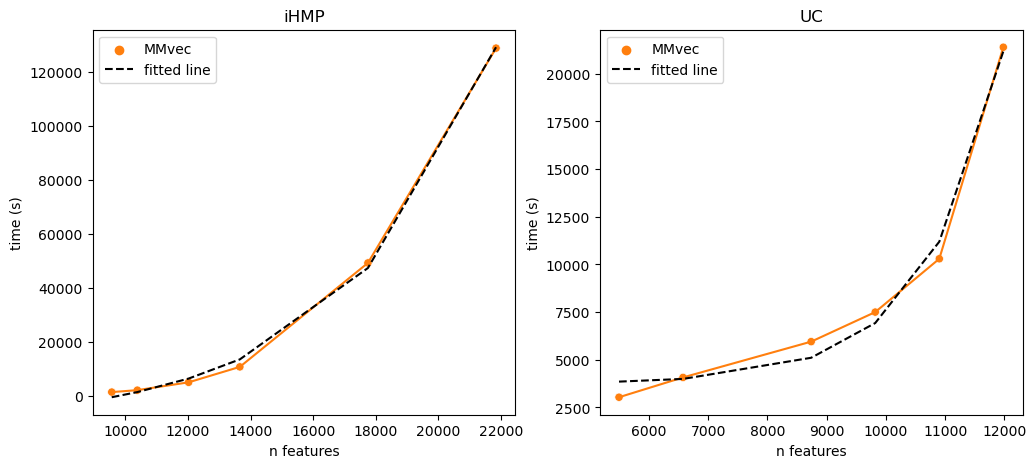

In [10]:
fig, axn = plt.subplots(1,2, figsize=(12,5))

ihmp_mmvec = ihmp_runtime_df[ihmp_runtime_df['method'] == 'MMvec']
uc_mmvec = uc_runtime_df[uc_runtime_df['method'] == 'MMvec']

xaxis = 'n features'

for ax_, df_, fit_, popt_, cohort_ in zip(axn.flatten(), 
                                          [ihmp_mmvec, uc_mmvec],
                                          [exp_curve_fit, exp_curve_fit],
                                          [popt_ihmp, popt_uc], ['iHMP', 'UC']):

    sns.scatterplot(ax=ax_, data=df_, x=xaxis, y='time (s)', 
                    hue='method', style='method', 
                    palette={'MMvec':'tab:orange'})
    ax_.plot(df_[xaxis], df_['time (s)'], 
            'tab:orange', label=None)
    ax_.plot(df_[xaxis], 
            fit_(df_[xaxis], *popt_), 'k--',
            label='fitted line')
    ax_.set_xlabel(xaxis)
    ax_.set_ylabel('time (s)')
    ax_.legend()
    ax_.set_title(cohort_)

plt.show()

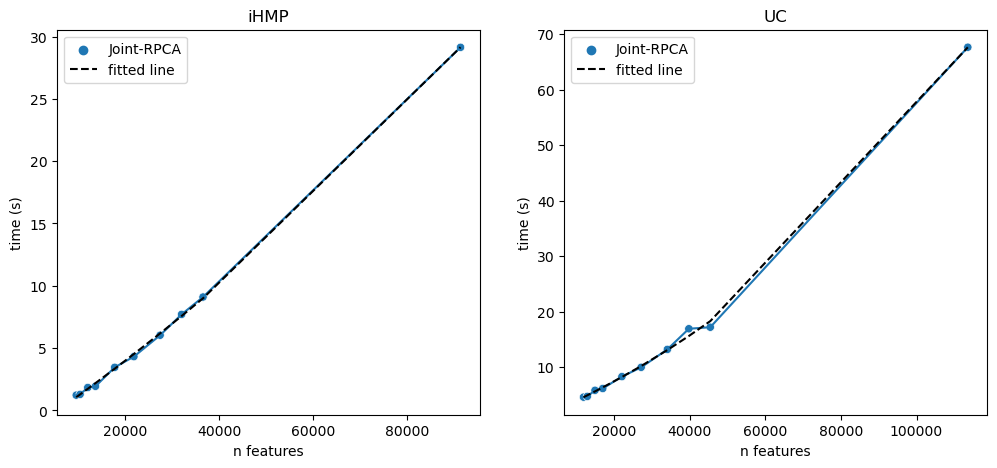

In [11]:
fig, axn = plt.subplots(1,2, figsize=(12,5))

ihmp_joint = ihmp_runtime_df[ihmp_runtime_df['method'] == 'Joint-RPCA']
uc_joint = uc_runtime_df[uc_runtime_df['method'] == 'Joint-RPCA']
xaxis = 'n features'

for ax_, df_, fit_, popt_, cohort_ in zip(axn.flatten(), 
                                         [ihmp_joint, uc_joint],
                                         [exp_curve_joint, exp_curve_joint],
                                         [joint_popt_ihmp, joint_popt_uc], 
                                         ['iHMP', 'UC']):

    sns.scatterplot(ax=ax_, data=df_, x=xaxis, y='time (s)', 
                    hue='method', style='method', 
                    palette={'Joint-RPCA':'tab:blue'})
    ax_.plot(df_[xaxis], df_['time (s)'], 
            'tab:blue', label=None)
    ax_.plot(df_[xaxis], 
            fit_(df_[xaxis], *popt_), 'k--',
            label='fitted line')
    ax_.set_xlabel(xaxis)
    ax_.set_ylabel('time (s)')
    ax_.legend()
    ax_.set_title(cohort_)

plt.show()

## Estimate additional datapoints

In [12]:
## estimate data points for MMvec-iHMP based on fitted curve
p_features = [30.0, 35.0, 40.0]
n_features = [int(0.01 * p * 91429.00) for p in p_features]
est_time = exp_curve_fit(np.array(n_features), *popt_ihmp)
#for the smaller datapoints, we will duplicate the first data point
p_features2 = [4.8, 5.8, 7.7, 8.7, 9.6]
n_features2 = [int(0.01 * p * 91429.00) for p in p_features2]
est_time2 = ihmp_mmvec.loc[0, 'time (s)'] * np.ones(len(n_features2))

#create dataframe
mmvec_extra_df = pd.DataFrame({'method':'MMvec', 
                               'time (s)':list(est_time)+list(est_time2),
                               'n features':list(n_features)+list(n_features2), 
                               '% features':list(p_features)+list(p_features2)})
#mmvec_extra_df

In [13]:
#repeat for Joint-RPCA
#for the smaller datapoints, we will duplicate the first data point
#p_features and n_features are the same
est_time3 = ihmp_joint.loc[0, 'time (s)'] * np.ones(len(n_features2))

#create dataframe
joint_extra_df = pd.DataFrame({'method':'Joint-RPCA', 
                               'time (s)':est_time3,
                               'n features':n_features2, 
                               '% features':p_features2})
#joint_extra_df

In [14]:
ihmp_runtime_all = ihmp_runtime_df.copy()
ihmp_runtime_all = pd.concat([ihmp_runtime_all, mmvec_extra_df, joint_extra_df], ignore_index=True)
ihmp_runtime_all['time (hr)'] = ihmp_runtime_all['time (s)'] / 3600
ihmp_runtime_all.sort_values(by='n features', inplace=True)
#ihmp_runtime_all

In [15]:
#map unique % features to an index
p_features_map = {p:i for i, p in enumerate(p_features_all)}
ihmp_runtime_all['% features index'] = ihmp_runtime_all['% features'].map(p_features_map)
#ihmp_runtime_all

In [16]:
#repeat for uc
#for mmvec, add the extra data points
p_features_uc = [11.3, 13.1, 14.9, 19.4] #23.9] #30.0, 35.0, 40.0]
n_features_uc = [int(0.01 * p * 113576.00) for p in p_features_uc]
est_time_uc = exp_curve_fit(np.array(n_features_uc), *popt_uc)
method_uc = ['MMvec'] * len(n_features_uc)
#for joint-rpca, add smaller data points
p_features3 = [4.8, 5.8, 7.7, 8.7, 9.6]
n_features3 = [int(0.01 * p * 91429.00) for p in p_features3]
est_time_joint = uc_joint.loc[0, 'time (s)'] * np.ones(len(n_features3))
method_joint = ['Joint-RPCA'] * len(n_features3)
#create dataframe
extra_df_uc = pd.DataFrame({'method':method_uc+method_joint,
                            'time (s)':list(est_time_uc)+list(est_time_joint),
                            'n features':list(n_features_uc)+list(n_features3), 
                            '% features':list(p_features_uc)+list(p_features3)})

In [17]:
uc_runtime_all = uc_runtime_df.copy()
uc_runtime_all = pd.concat([uc_runtime_all, extra_df_uc], ignore_index=True)
uc_runtime_all['time (hr)'] = uc_runtime_all['time (s)'] / 3600
uc_runtime_all.sort_values(by='% features', inplace=True)
#uc_runtime_all

In [18]:
#map unique % features to an index
p_features_all = uc_runtime_all['% features'].astype(float).unique()
p_features_map = {p:i for i, p in enumerate(p_features_all)}
uc_runtime_all['% features index'] = uc_runtime_all['% features'].map(p_features_map)
#uc_runtime_all

## Compare runtimes

In [19]:
#the dfs below are used for labeling a few datapoints (runtimes)
ihmp_joint = ihmp_runtime_all[ihmp_runtime_all['method'] == 'Joint-RPCA']
ihmp_mmvec = ihmp_runtime_all[ihmp_runtime_all['method'] == 'MMvec']
ihmp_joint.reset_index(drop=True, inplace=True)
ihmp_mmvec.reset_index(drop=True, inplace=True)

uc_joint = uc_runtime_all[uc_runtime_all['method'] == 'Joint-RPCA']
uc_mmvec = uc_runtime_all[uc_runtime_all['method'] == 'MMvec']
uc_joint.reset_index(drop=True, inplace=True)
uc_mmvec.reset_index(drop=True, inplace=True)

In [20]:
#more formatting
ihmp_runtime_all.reset_index(drop=True, inplace=True)
ihmp_runtime_all['method'] = ihmp_runtime_all['method'].astype('str')
ihmp_runtime_all['method_detailed'] = ihmp_runtime_all['method'].copy()

uc_runtime_all.reset_index(drop=True, inplace=True)
uc_runtime_all['method'] = uc_runtime_all['method'].astype('str')
uc_runtime_all['method_detailed'] = uc_runtime_all['method'].copy()

#note which values are estimated
#joint-RCPA
ihmp_runtime_all['method_detailed'] = np.where((ihmp_runtime_all['method'] == 'Joint-RPCA') & (ihmp_runtime_all['% features'] < 10),
                                               'joint_estimated', ihmp_runtime_all['method_detailed'])
uc_runtime_all['method_detailed'] = np.where((uc_runtime_all['method'] == 'Joint-RPCA') & (uc_runtime_all['% features'] < 10),
                                               'joint_estimated', uc_runtime_all['method_detailed'])
#MMvec iHMP
ihmp_runtime_all['method_detailed'] = np.where((ihmp_runtime_all['method'] == 'MMvec') & (ihmp_runtime_all['% features'] < 10),
                                               'mmvec_estimated1', ihmp_runtime_all['method_detailed'])
ihmp_runtime_all['method_detailed'] = np.where((ihmp_runtime_all['method'] == 'MMvec') & (ihmp_runtime_all['% features'] > 24),
                                               'mmvec_estimated2', ihmp_runtime_all['method_detailed'])
#MMvec UC
uc_runtime_all['method_detailed'] = np.where((uc_runtime_all['method'] == 'MMvec') & (uc_runtime_all['% features'] > 11),
                                              'mmvec_estimated', uc_runtime_all['method_detailed'])

In [21]:
#create small df to connect lines between hues
ihmp_runtime_all_small = ihmp_runtime_all[(ihmp_runtime_all['% features'] > 9) & (ihmp_runtime_all['% features'] < 11)]
ihmp_runtime_all_small2 = ihmp_runtime_all[(ihmp_runtime_all['% features'] > 23) & (ihmp_runtime_all['% features'] < 31) & 
                                                                                  (ihmp_runtime_all['method'] == 'MMvec')]
uc_runtime_all_small = uc_runtime_all[(uc_runtime_all['% features'] > 9) & (uc_runtime_all['% features'] < 12)]
#uc_runtime_all_small2 = uc_runtime_all[(uc_runtime_all['% features'] > 9) & (uc_runtime_all['% features'] < 11) & 
#                                                                            (uc_runtime_all['method'] == 'Joint-RPCA')]

In [22]:
#add one to % of features index -- useful later for plotting
for df in [ihmp_runtime_all_small, ihmp_runtime_all_small2, 
           uc_runtime_all_small, ihmp_runtime_all, uc_runtime_all]:
    df['% features index'] = df['% features index'] + 1

#add one to % of features index -- useful later for plotting
for df in [ihmp_joint, ihmp_mmvec, uc_joint, uc_mmvec]:
    df.index = df.index + 1

In [23]:
def round_to_n(x, n):
    " Round x to n significant figures "
    return round(x, -int(np.floor(np.sign(x) * np.log10(abs(x)))) + n)

def str_fmt(x, n=2):
    " Format x into nice Latex rounding to n"
    power = int(np.log10(round_to_n(x, 0)))
    f_SF = round_to_n(x, n) * pow(10, -power)
    return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(f_SF, power, 1)

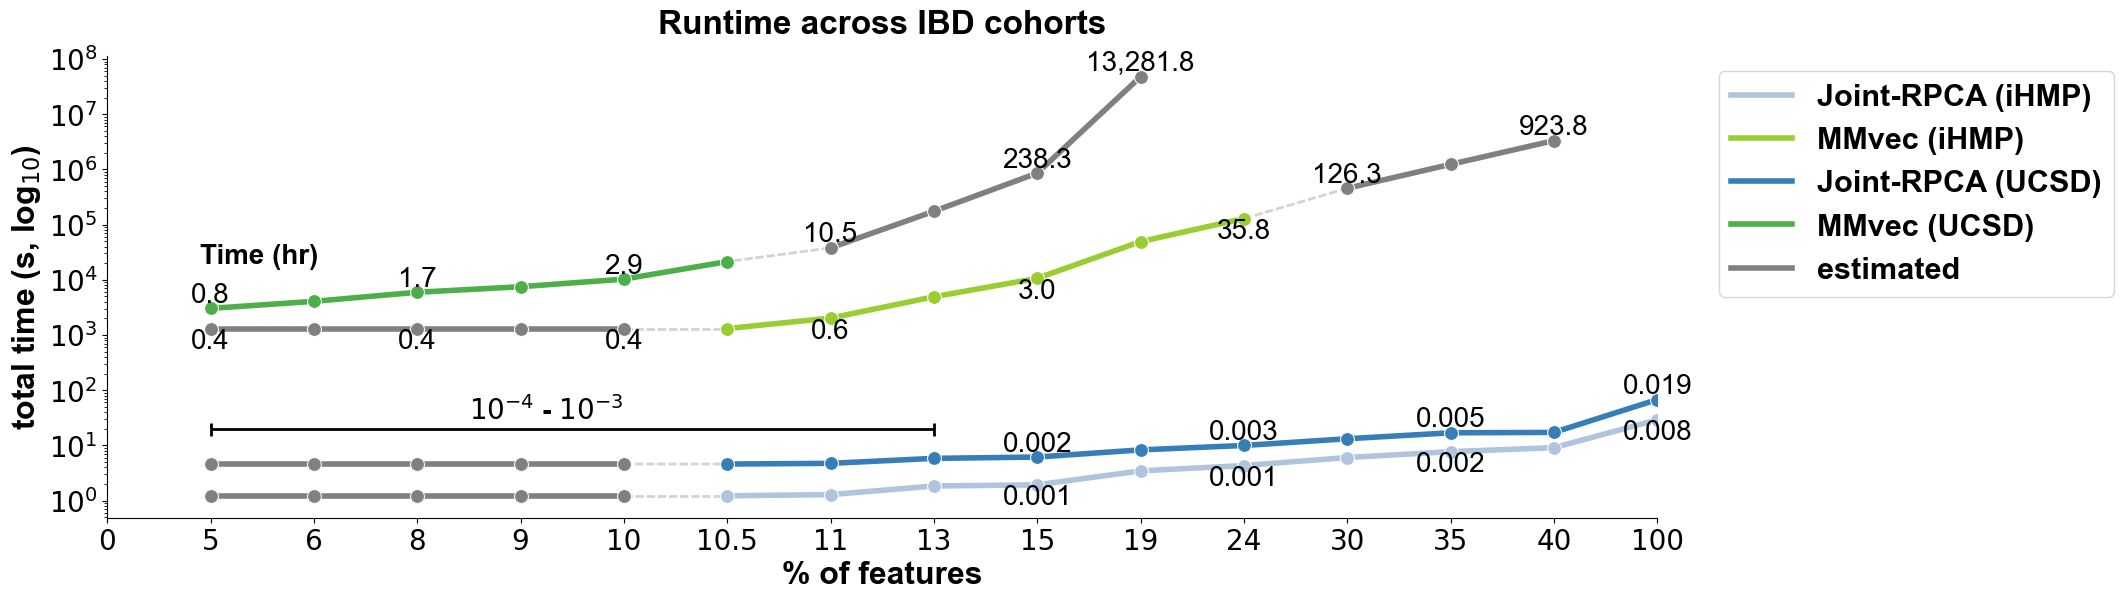

In [39]:
#estimate additional runtimes for MMvec using runtime
fig = plt.figure(figsize=(20, 6))

ihmp_palette = {'Joint-RPCA':'lightsteelblue', 'MMvec':'yellowgreen', 
                'joint_estimated':'gray', 'mmvec_estimated1':'gray',
                 'mmvec_estimated2':'gray'}
uc_palette = {'Joint-RPCA':'#377eb8', 'MMvec':'#4daf4a',
              'joint_estimated':'gray', 'mmvec_estimated':'gray'}
style_dict = {'Joint-RPCA': (3, 1), 'MMvec': (3, 1)}

#plot separate lines to connect between hues
ax1 = sns.lineplot(data=ihmp_runtime_all_small.copy(), x='% features index', y='time (s)', 
                   hue='method', palette={'Joint-RPCA':'lightgray', 'MMvec':'lightgray'},
                   style='method', dashes=style_dict, linewidth=2)
ax1.legend_.remove()

ax2 = sns.lineplot(data=ihmp_runtime_all_small2.copy(), x='% features index', y='time (s)', 
                   hue='method', palette={'Joint-RPCA':'lightgray', 'MMvec':'lightgray'},
                   style='method', dashes=style_dict, linewidth=2)
ax2.legend_.remove()

ax3 = sns.lineplot(data=uc_runtime_all_small.copy(), x='% features index', y='time (s)', 
                   hue='method', palette={'Joint-RPCA':'lightgray', 'MMvec':'lightgray'},
                   style='method', dashes=style_dict, linewidth=2)
ax3.legend_.remove()

#plot lines with hues added
ax4 = sns.lineplot(data=ihmp_runtime_all.copy(), x='% features index', y='time (s)', 
                    hue='method_detailed', linewidth=4,
                    hue_order=['Joint-RPCA','MMvec','joint_estimated',
                               'mmvec_estimated1','mmvec_estimated2'], 
                    palette=ihmp_palette, marker="o", markersize=10)

ax5 = sns.lineplot(data=uc_runtime_all.copy(), x='% features index', y='time (s)', 
                    hue='method_detailed', linewidth=4,
                    hue_order=['Joint-RPCA','MMvec','joint_estimated','mmvec_estimated'], 
                    palette=uc_palette, marker="o", markersize=10)
#log y axis
plt.yscale('log')
#increase font size
plt.ylabel('total time (s, log$_{10}$)', weight='bold',
           fontname='Arial', fontsize=23)
plt.yticks(fontsize=20)

#keep only half of the legend
handles, _ = plt.gca().get_legend_handles_labels()
handles = handles[5:]
handles_keep = np.concatenate([handles[0:2], handles[5:8]])
labels = ['Joint-RPCA (iHMP)', 'MMvec (iHMP)', 
          'Joint-RPCA (UCSD)', 'MMvec (UCSD)', 'estimated']
legend = plt.legend(handles_keep, labels, 
                    prop={'size':22, 'weight':'semibold', 'family':'Arial'}, 
                    ncol=1, bbox_to_anchor=(1.03, 1), fancybox=True)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)

#get yticks
y_lim1 = plt.gca().get_ylim()
y_ticks = plt.gca().get_yticks()

#change xticks labels
all_p_features = sorted(list(ihmp_runtime_all['% features'].unique()))
all_p_features = [round(p, 1) for p in all_p_features]
all_p_features_plot = [0] + list(all_p_features)

all_p_features_plot_v2 = [0,5,6,8,9,10,10.5,11,13,15,19,24,30,35,40,100]
plt.xticks(list(range(0, len(all_p_features_plot))), 
           all_p_features_plot_v2, fontsize=20)
plt.xlim([0, len(all_p_features_plot)-1])
plt.xlabel('% of features', fontname='Arial', fontsize=23, weight='bold')

#add horizontal lines to show the runtime of the estimated points
plt.hlines(y=2e1, xmin=1, xmax=8, color='black', linestyle='-', lw=2)
plt.text(3.5, 3e1, "$10^{-4}$ - $10^{-3}$", ha='left', 
         fontsize=20, fontweight='semibold', fontname='Arial')
# Add vertical lines at the ends of the horizontal line
plt.vlines(x=1, ymin=1.5e1, ymax=2.5e1, color='black', lw=2)
plt.vlines(x=8, ymin=1.5e1, ymax=2.5e1, color='black', lw=2)

#add text to every other point to show the time in seconds
plt.text(0.9, 2e4, "Time (hr)", ha='left', fontsize=20, 
         fontweight='semibold', fontname='Arial')
for i, p in enumerate(all_p_features):
    j = i + 1
    if (i % 2 == 0 and j >= 8):
        #joint-rpca
        y_ihmp_joint = ihmp_joint.loc[j, 'time (s)']
        txt_ihmp_joint = round(y_ihmp_joint/3600, 3)
        plt.text(j, y_ihmp_joint, txt_ihmp_joint, fontsize=20,
                 ha='center', va='top', fontname='Arial')
        
        y_uc_joint = uc_joint.loc[j, 'time (s)']
        txt_uc_joint = round(y_uc_joint/3600, 3)
        plt.text(j, y_uc_joint, txt_uc_joint, fontsize=20,
                 ha='center', va='bottom', fontname='Arial')
    
    if (i % 2 == 0 and j <= 10) or (j==10):
        #mmvec - GOOD
        y_uc_mmvec = uc_mmvec.loc[j, 'time (s)']
        txt_uc_mmvec = round(y_uc_mmvec/3600, 1)
        txt_uc_mmvec = '{:,}'.format(txt_uc_mmvec)
        plt.text(j, y_uc_mmvec, txt_uc_mmvec, fontsize=20,
                 ha='center', va='bottom', fontname='Arial')
    
    if (i % 2 == 0 and j < 12):
        #mmvec
        y_ihmp_mmvec = ihmp_mmvec.loc[j, 'time (s)']
        txt_ihmp_mmvec = round(y_ihmp_mmvec/3600, 1)
        plt.text(j, y_ihmp_mmvec, txt_ihmp_mmvec, fontsize=20, 
                 ha='center', va='top', fontname='Arial')
        
    if (j==12) or (j==14):
        #mmvec
        y_ihmp_mmvec = ihmp_mmvec.loc[j, 'time (s)']
        txt_ihmp_mmvec = round(y_ihmp_mmvec/3600, 1)
        plt.text(j, y_ihmp_mmvec, txt_ihmp_mmvec, fontsize=20,
                 ha='center', va='bottom', fontname='Arial')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

plt.title('Runtime across IBD cohorts', y=1.03,
          color='black', weight='bold',
          fontsize=24, fontname='Arial')
plt.savefig('../../results/figure-3E.pdf', 
           dpi=600, bbox_inches='tight',
           facecolor=fig.get_facecolor())
plt.savefig('../../results/figure-3E.png', 
           dpi=600, bbox_inches='tight',
           facecolor=fig.get_facecolor())
plt.show()

In [25]:
stop

NameError: name 'stop' is not defined

In [ ]:
#small tweaks before saving tables
ihmp_runtime_all['method_detailed'] = np.where((ihmp_runtime_all['method_detailed'] == 'joint_estimated') | 
                                               (ihmp_runtime_all['method_detailed'] == 'mmvec_estimated1') |
                                               (ihmp_runtime_all['method_detailed'] == 'mmvec_estimated2'),
                                               'Estimated', ihmp_runtime_all['method_detailed'])
#drop % features index
ihmp_runtime_all.drop(columns=['% features index'], inplace=True)
#reorder columns
ihmp_runtime_all = ihmp_runtime_all[['method', 'method_detailed', 'n features', '% features', 'time (s)', 'time (hr)']]

In [ ]:
#repeat for UCSD
uc_runtime_all['method_detailed'] = np.where((uc_runtime_all['method_detailed'] == 'joint_estimated') | 
                                             (uc_runtime_all['method_detailed'] == 'mmvec_estimated'),
                                              'Estimated', uc_runtime_all['method_detailed'])
#drop % features index
uc_runtime_all.drop(columns=['% features index'], inplace=True)
#reorder columns
uc_runtime_all = uc_runtime_all[['method', 'method_detailed', 'n features', '% features', 'time (s)', 'time (hr)']]

In [ ]:
#save to csv
ihmp_runtime_all.to_csv('../../results/supp-table-6.1-ihmp-runtime.csv', index=False)
uc_runtime_all.to_csv('../../results/supp-table-6.2-ucsd-runtime.csv', index=False)